In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from ipynb.fs.full.UtilFunctions import format_season

In [2]:
def pre_process(seasons):
    df = None
    for season in seasons:
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/PlayerClustering/player_stats_and_cluster{first_year}-{second_year}.csv")
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [3]:
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [4]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [5]:
def print_clusters(df, n):
    for i in range(n):
        print("Cluster",i)
        print(df[df['Cluster'] == i].head(10)[['Player']])
        print()

## Pre-processing - gathering data from the last 6 seasons

In [6]:
df = pre_process(range(2017, 2023))

## Feature selection, splitting into training/testing

In [7]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm", "Cluster"])]
target = df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

In [8]:
print_clusters(df, 5)

Cluster 0
               Player
0       Marcin Gortat
15        Rudy Gobert
16        Greg Monroe
22       Myles Turner
24     Andre Drummond
27     DeAndre Jordan
31       Steven Adams
37  Jonas Valančiūnas
56          David Lee
62   Tristan Thompson

Cluster 1
                 Player
1        Justin Holiday
2            Joe Ingles
9          Jamal Murray
12       Jamal Crawford
19  Dorian Finney-Smith
20       T.J. McConnell
26     Domantas Sabonis
28          Dario Šarić
30          Cory Joseph
32          Patty Mills

Cluster 2
                   Player
13     Karl-Anthony Towns
17      Russell Westbrook
23           James Harden
29            CJ McCollum
34  Giannis Antetokounmpo
44           Kemba Walker
46          Stephen Curry
68              John Wall
73           Bradley Beal
84          Isaiah Thomas

Cluster 3
             Player
3    Andrew Wiggins
6     Tobias Harris
7       Jeff Teague
8     Elfrid Payton
11  Jordan Clarkson
21        Ish Smith
36     Trevor Ariza
41  O

## Randomly select better parameters for Random Forest and fit the data

In [9]:
rf = random_forest_classify(X_train, y_train)

In [10]:
y_pred = rf.predict(X_test)

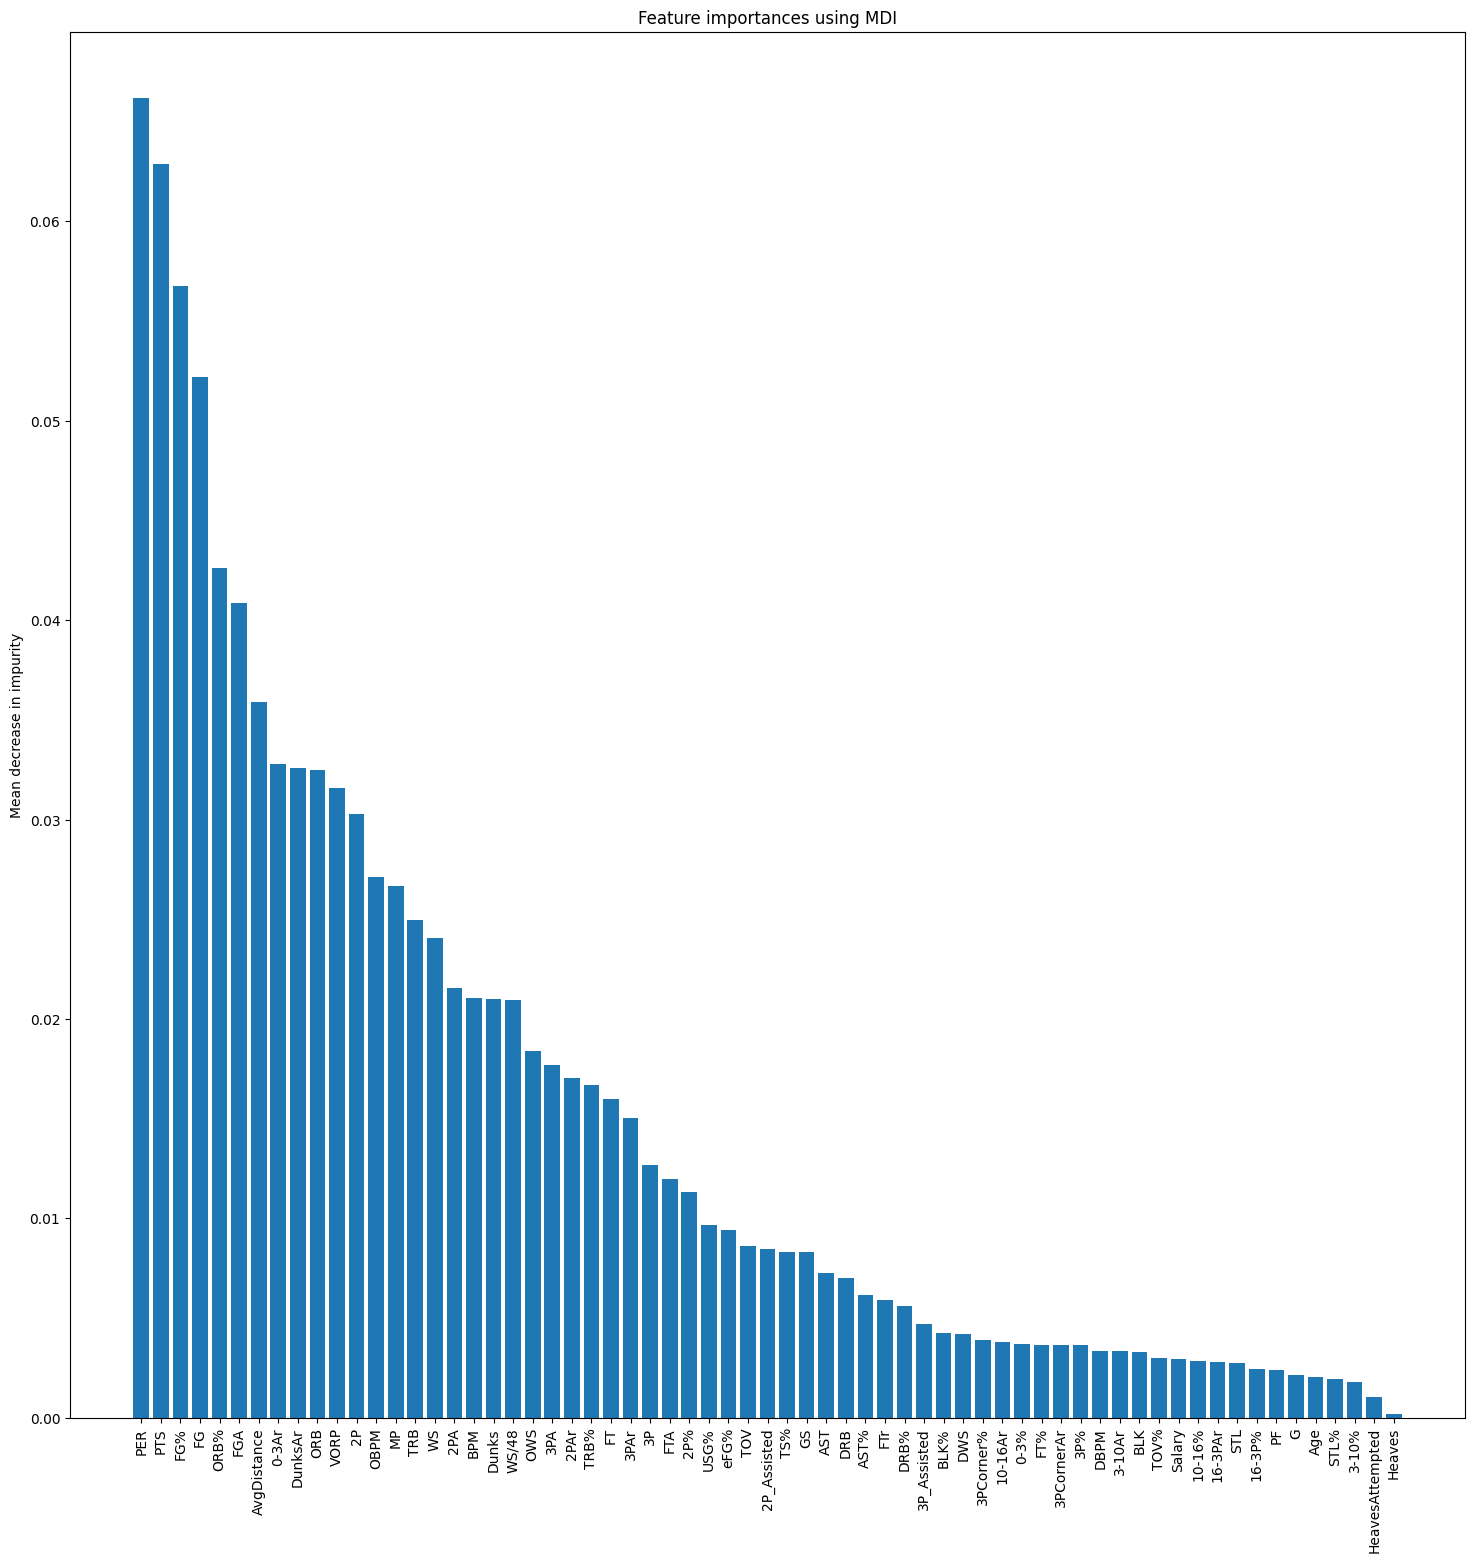

In [11]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm', 'Cluster']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

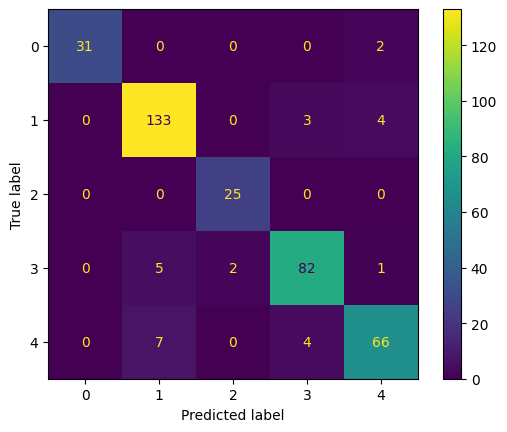

In [12]:
labels = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [13]:
accuracy_score(y_test, y_pred)

0.9232876712328767

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        33
           1       0.92      0.95      0.93       140
           2       0.93      1.00      0.96        25
           3       0.92      0.91      0.92        90
           4       0.90      0.86      0.88        77

    accuracy                           0.92       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.92      0.92      0.92       365



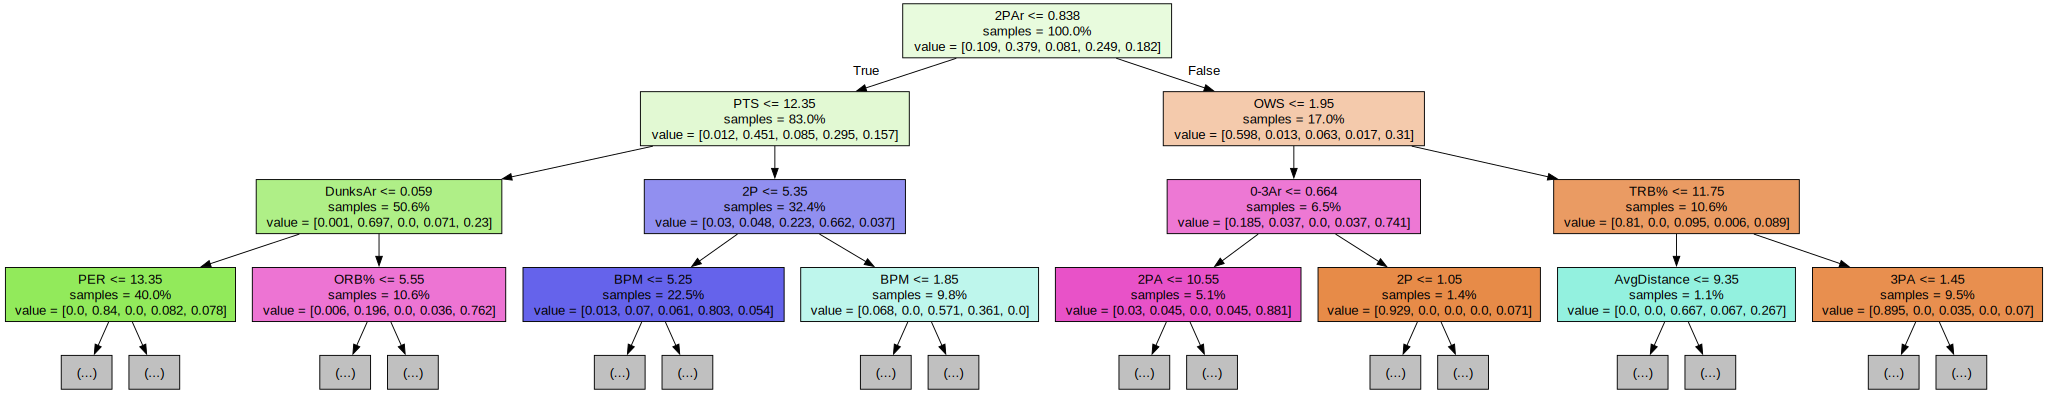

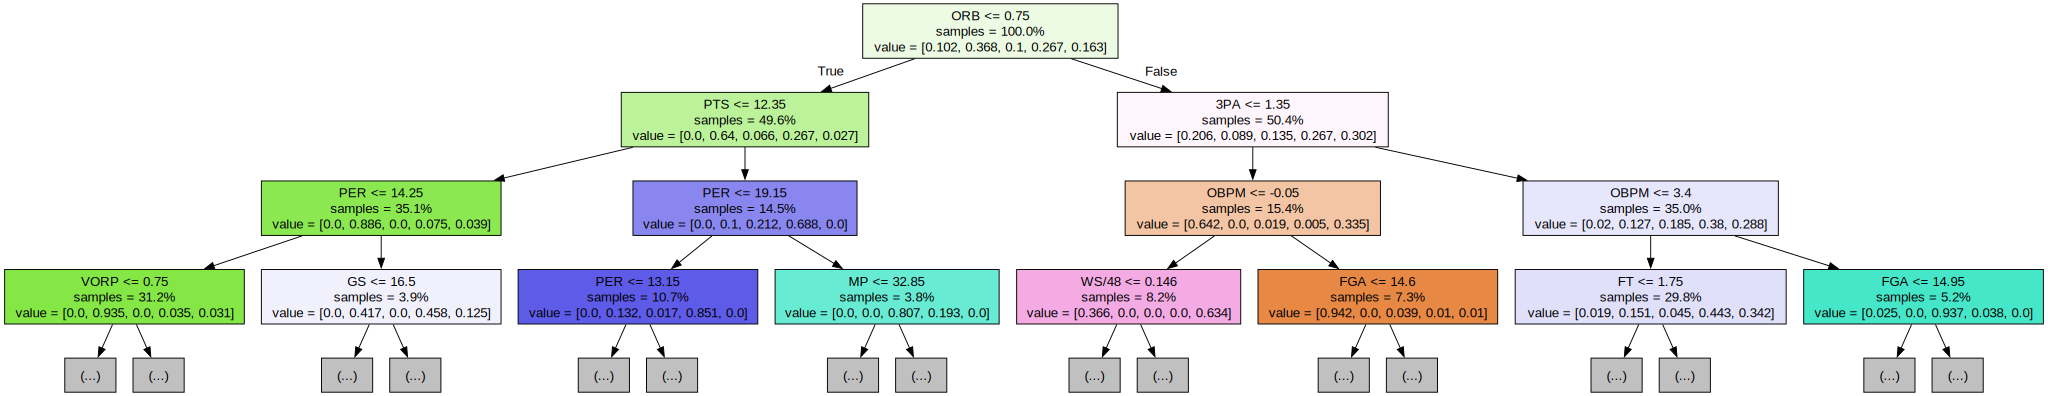

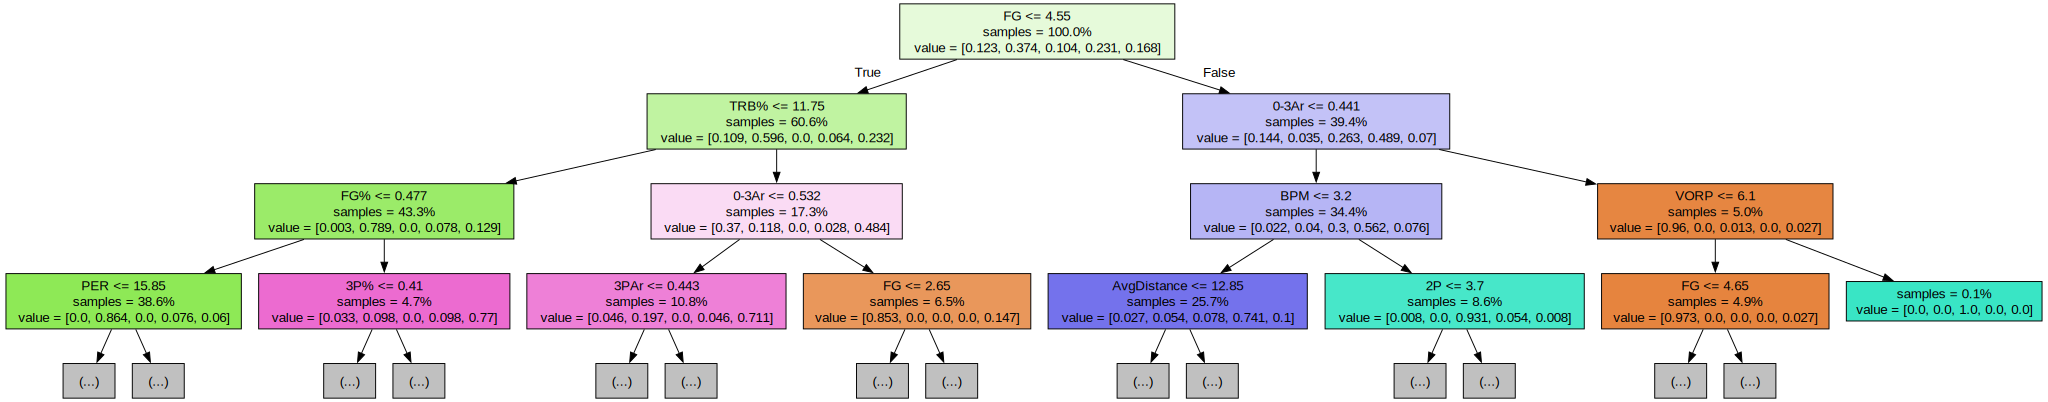

In [16]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)